In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from torchvision.utils import make_grid
import os

In [3]:
import sys

sys.path.append("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.attack.naturalness import AdvContentLoss
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates
from adv_manhole.texture_mapping.depth_mapping import DepthTextureMapping

The console stream is logged into /home/carla_client/sg_logs/console.log


[2024-05-31 10:14:57] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


## Load Dataset

In [4]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/")
print(carla_dataset)

In [5]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config"]
)

data_iterable = {}
batch_size = 8

for data_type, dataset in filtered_columns_dataset.items():
    data_iterable[data_type] = dataset.to_iterable_dataset()
    data_iterable[data_type] = data_iterable[data_type].map(
        lambda example: {
            "local_surface_coors": transforms.ToTensor()(
                process_surface_coordinates(example["raw_depth"], example["camera_config"])
            ),
            "rgb": transforms.ToTensor()(example["rgb"]),
        },
        remove_columns=["raw_depth", "camera_config"],
    )
    data_iterable[data_type] = DataLoader(
        data_iterable[data_type],
        batch_size=batch_size,
    )

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})


## Load Target Model

In [6]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-05-31 10:15:15] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https:/

In [7]:
original_index = 0 # Road
# target_indices = list(range(1, 13))  # All classes except Road
target_indices = [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18]  # Building, Wall, Fence, Pole, Traffic Light, Traffic Sign, Person, Rider, Car, Truck, Bus, Train, Motorcycle, Bicycle

## Load Manhole Candidates

In [8]:
imsize = 224  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to("cuda", torch.float)

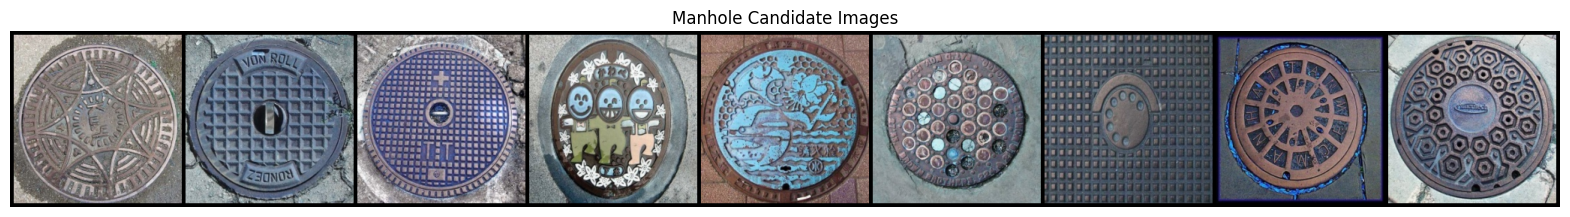

In [9]:
manhole_candidate_path = "/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/manhole"

# Load the candidate images
candidate_images = []
for filename in os.listdir(manhole_candidate_path):
    candidate_img = image_loader(f"{manhole_candidate_path}/{filename}")
    candidate_images.append(candidate_img)

candidate_images = torch.cat(candidate_images, dim=0)

# Plot the candidate images in a grid format
plt.figure(figsize=(20, 5))
plt.imshow(
    np.transpose(
        make_grid(candidate_images, nrow=10, padding=5).cpu(),
        (1, 2, 0),
    )
)
plt.title("Manhole Candidate Images")
plt.axis("off")
plt.show()

In [10]:
adv_content_loss = AdvContentLoss(
    candidate_images=candidate_images,
)

/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/adv_manhole/attack/naturalness.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/adv_manhole/attack/naturalness.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [11]:
adversarial_losses = AdvManholeLosses(
    adv_content_loss=adv_content_loss,
    mde_loss_weight=2.0,
    ss_ua_loss_weight=0.5,
    ss_ta_loss_weight=0.5,
    tv_loss_weight=1.0,
    content_loss_weight=0.5,
    background_loss_weight=0.0
)

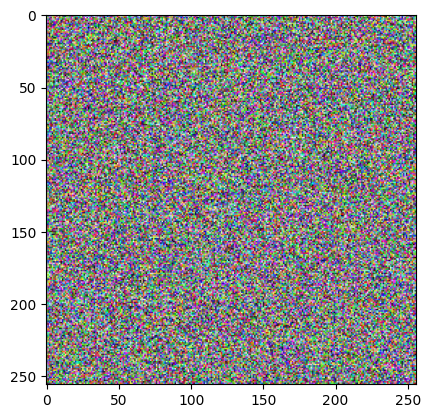

In [12]:
import torch.optim as optim
from tqdm import tqdm

adversarial_texture = torch.rand((3, 256, 256)).cuda()
patch_texture_var = torch.nn.Parameter(adversarial_texture, requires_grad=True)

# Define the optimization pipeline
optimizer = optim.Adam([patch_texture_var], lr=0.01)

# Plot patch_texture_var
plt.imshow(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [13]:
train_total_batch = len(filtered_columns_dataset["train"]) // batch_size + 1 if len(filtered_columns_dataset["train"]) % batch_size != 0 else 0
val_total_batch = len(filtered_columns_dataset["validation"]) // batch_size + 1 if len(filtered_columns_dataset["validation"]) % batch_size != 0 else 0
test_total_batch = len(filtered_columns_dataset["test"]) // batch_size + 1 if len(filtered_columns_dataset["test"]) % batch_size != 0 else 0

In [14]:
# Create color jitter transform for data augmentation
texture_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]
)

output_augmentation = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.1),
    ]
)

In [15]:
output_path = "/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle"
os.makedirs(output_path, exist_ok=True)

In [16]:
depth_planar_mapping = DepthTextureMapping(
    random_scale=(0.0, 0.01),
    with_circle_mask=True,
    device="cuda",
)

In [17]:
def forward(
        batch, 
        patch_texture_var, 
        depth_planar_mapping: DepthTextureMapping, 
        adversarial_losses: AdvManholeLosses, 
        device
    ):
    
    rgb = batch["rgb"].to(device)
    local_surface_coors = batch["local_surface_coors"].to(device)

    current_batch_size = rgb.shape[0]

    # Repeat the texture to match the batch size
    batched_texture = patch_texture_var.unsqueeze(0).repeat(
        current_batch_size, 1, 1, 1
    )

    # Augment the texture with color jitter
    augmented_texture = torch.stack(
        [
            texture_augmentation(batched_texture[i])
            for i in range(current_batch_size)
        ]
    )

    final_images, texture_masks = depth_planar_mapping(
        augmented_texture, local_surface_coors, rgb, current_batch_size
    )

    # Apply the output augmentation
    augmented_final_images = torch.stack(
        [
            output_augmentation(final_images[i])
            for i in range(current_batch_size)
        ]
    )

    # Predict the depth and semantic segmentation
    predicted_disp = monodepth2_model(final_images) #augmented_final_images)
    predicted_semantic = ddrnet_model(augmented_final_images)

    losses = adversarial_losses(
        patch_texture_var,
        final_images,
        texture_masks,
        rgb,
        predicted_disp,
        torch.ones_like(predicted_disp),
        predicted_semantic,
        original_index,
        target_indices
    )

    return {
        "loss": losses,
        "final_images": final_images,
        "augmented_final_images": augmented_final_images,
        "texture_masks": texture_masks,
        "predicted_disp": predicted_disp,
        "predicted_semantic": predicted_semantic,
    }

In [18]:
import random
log_prediction_every = 5

In [21]:
# Wandb setup
import wandb

run = wandb.init(
    project="adversarial-manhole",
    entity="naufalso",
    name="near_patch_targeted_poc_full_robust_natural_circle",
    config={
        "mde_model": "mono_640x192",
        "ss_model": "ddrnet_23",
        "texture_size": 0.5,
        "rand_texture_shift_x": [0.0, 0.4],
        "rand_texture_shift_y": [-0.4, 0.4],
        "rand_texture_size": [0.5, 0.51],
        "texture_res": 256,
        "mde_loss_weight": 2.0,
        "ss_ua_loss_weight": 0.5,
        "ss_ta_loss_weight": 0.5,
        "tv_loss_weight": 1.0,
        "content_loss_weight": 0.5,
        "background_loss_weight": 0.0,
        "lr": 0.01,
        "batch_size": 8,
        "epochs": 25,
        "texture_augmentation": {
            "brightness": 0.2,
            "contrast": 0.1,
        },
        "output_augmentation": {
            "brightness": 0.2,
            "contrast": 0.1,
        },
    }
)

epochs = 25

[2024-05-31 10:16:47] ERROR - jupyter.py - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: naufalso. Use `wandb login --relogin` to force relogin


In [22]:
epochs = 25

train_epoch_history = defaultdict(list)
val_epoch_history = defaultdict(list)

for epoch in range(epochs):
    # Train iteration
    with tqdm(
        data_iterable['train'], total=train_total_batch, desc=f"Train Epoch {epoch + 1}/{epochs}"
    ) as train_pbar:
        train_history = defaultdict(list)
        for batch in train_pbar:
            optimizer.zero_grad()

            results = forward(batch, patch_texture_var, depth_planar_mapping, adversarial_losses, device="cuda")

            # Backpropagate the loss
            results['loss']["total_loss"].backward()
            optimizer.step()

            # Clip the texture to [0, 1]
            patch_texture_var.data.clamp_(0, 1)

            # Update the progress bar
            train_pbar.set_postfix(
                {
                    key: value.item() if isinstance(value, torch.Tensor) else value
                    for key, value in results['loss'].items()
                    if 'loss' in key
                }
            )

            # Update the train history
            for key, value in results['loss'].items():
                if 'loss' in key:
                    train_history[key].append(value.item() if isinstance(value, torch.Tensor) else value)

        for key, value in train_history.items():
            mean_value = np.mean(value)
            train_epoch_history[key].append(mean_value)
            run.log({f"train/{key}": mean_value}, commit=False)

        # Save the texture as image
        Image.fromarray((patch_texture_var.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)).save(
            os.path.join(output_path, f"texture_epoch_{epoch}.png")
        )

    # Validation iteration
    with tqdm(
        data_iterable['validation'], total=val_total_batch, desc=f"Validation {epoch + 1}/{epochs}"
    ) as val_pbar:
        val_history = defaultdict(list)
        for batch in val_pbar:
            with torch.no_grad():
                results = forward(batch, patch_texture_var, depth_planar_mapping, adversarial_losses, device="cuda")

            # Update the progress bar
            val_pbar.set_postfix(
                {
                    key: value.item() if isinstance(value, torch.Tensor) else value
                    for key, value in results['loss'].items()
                    if 'loss' in key
                }
            )

            # Update the validation history
            for key, value in results['loss'].items():
                if 'loss' in key:
                    val_history[key].append(value.item() if isinstance(value, torch.Tensor) else value)

        for key, value in val_history.items():
            mean_value = np.mean(value)
            val_epoch_history[key].append(mean_value)
            run.log({f"val/{key}": mean_value}, commit=False)

    # Log the visualizations
    if epoch % log_prediction_every == 0:
        augmented_final_images = results["augmented_final_images"]
        predicted_disp = results["predicted_disp"]
        predicted_semantic = results["predicted_semantic"]

        random_idx = random.randint(0, augmented_final_images.shape[0] - 1)

        disp_pred_fig = monodepth2_model.plot(
            augmented_final_images[random_idx].permute(1, 2, 0).detach().cpu().numpy(),
            predicted_disp[random_idx],
        )

        semantic_pred_fig = ddrnet_model.plot(
            augmented_final_images[random_idx].permute(1, 2, 0).detach().cpu().numpy(),
            predicted_semantic[random_idx],
        )

        run.log(
            {
                "val/disp_pred": disp_pred_fig,
                "val/semantic_pred": semantic_pred_fig,
            },
            commit=False
        )

    # Log the texture to wandb
    run.log({"texture": wandb.Image(patch_texture_var.permute(1, 2, 0).detach().cpu().numpy())})


Train Epoch 1/25:   0%|          | 0/200 [00:00<?, ?it/s]/home/carla_client/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Train Epoch 1/25: 100%|██████████| 200/200 [06:53<00:00,  2.07s/it, total_loss=6.13, mde_loss=1.58, ss_ua_loss=0.524, ss_ta_loss=2.49, tv_loss=0.403, content_loss=1.13, background_loss=0] 


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [26]:
for key, value in train_history.items():
    print(key, value[0])

total_loss tensor(11.2666, device='cuda:0', grad_fn=<AddBackward0>)
mde_loss tensor(1.7014, device='cuda:0', grad_fn=<MulBackward0>)
ss_ua_loss tensor(2.1411, device='cuda:0', grad_fn=<MulBackward0>)
ss_ta_loss tensor(3.2860, device='cuda:0', grad_fn=<MulBackward0>)
tv_loss tensor(0.6673, device='cuda:0', grad_fn=<MulBackward0>)
content_loss tensor(3.4708, device='cuda:0', grad_fn=<MulBackward0>)
background_loss 0.0


In [ ]:
run.finish()